In [6]:
import os
import re
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk

import spacy

from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
%matplotlib inline

<a id='Data_Preparation_Data_Exploration'></a>
# Data Preparation

Data cleaning is a crucial and often time-consuming step in the machine learning (ML) pipeline. It involves identifying and correcting errors, inconsistencies, and inaccuracies in the dataset to ensure that the data used for training and testing ML models is of high quality and reliable. The importance of data cleaning for ML cannot be overstated, and here are several reasons why it is essential:

1. **Improves Performance**: Clean data leads to better model accuracy.

2. **Enhances Generalization**: Helps models make accurate predictions on new data.

3. **Reduces Bias**: Mitigates data biases for fairer predictions.

4. **Facilitates Interpretation**: Clean data is easier to understand.

5. **Saves Time**: Prevents retraining due to data issues.

6. **Ensures Compliance**: Meets regulatory and ethical standards.

7. **Increases Robustness**: Models handle variations better.

In [7]:
os.listdir("../data/nlp-getting-started/")


['test.csv', 'train.csv', 'sample_submission.csv']

In [8]:
train = pd.read_csv("../data/nlp-getting-started/train.csv")
test = pd.read_csv("../data/nlp-getting-started/test.csv")

In [9]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train["is_train"] = True
test["is_train"] = False

train_test = pd.concat([train, test]).reset_index(drop=True)


## NLP specific

Text cleaning is a crucial preprocessing step in NLP that involves preparing raw text data for analysis. Cleaning text data helps remove noise, inconsistencies, and irrelevant information, making it easier for machine learning models to extract meaningful patterns and insights from the text. 

### Lowercasing

Lowercasing in NLP involves converting all text to lowercase, and it's a common preprocessing step.

Lowercasing provides several advanteges, which is why it is so popular in NLP data prerocessing:

1. **Consistency**: Lowercasing ensures that all words are in a consistent format, avoiding inconsistencies in capitalization, which can confuse models. *Example*: words at the start of the sentence.
2. **Normalization**: Lowercasing normalizes text data, making it easier to compare, process, and analyze.
3. **Efficiency**: Lowercasing can improve computational efficiency by reducing the dimensionality of text data and making it easier for models to process.
4. **Compatibility**: Many NLP libraries and models are designed to work with lowercase text. Using lowercase text ensures compatibility with these tools.

**⚠️ Note!**

As any processing, it is task and domain/data specific wheather you should use lowercasing. In some NLP tasks, preserving letter case is crucial, as well as you can lose critical information of the data, by converting it all to lowercase.

In [11]:
some_sentence = """The No Free Lunch Theorem (NFLT) states that: "In the field of machine learning and optimization, there is no one-size-fits-all algorithm or model that performs best for all possible tasks and datasets. The performance of algorithms and models is problem-specific, and there is no universal 'free lunch' algorithm that excels in every scenario."""
print(some_sentence.lower())

the no free lunch theorem (nflt) states that: "in the field of machine learning and optimization, there is no one-size-fits-all algorithm or model that performs best for all possible tasks and datasets. the performance of algorithms and models is problem-specific, and there is no universal 'free lunch' algorithm that excels in every scenario.


### Stopwords
In NLP, stopwords are words that are **commonly used** in a language **but** are generally considered to be of **little value** when it comes to extracting meaningful information from text. 

These words are often filtered out or removed from the text during the preprocessing phase because they don't carry significant meaning on their own and can potentially introduce noise into NLP tasks. Stopwords typically include common words like articles, prepositions, conjunctions, and pronouns.

Examples of stopwords in English include words like:

![images/stopwords_example.png](images/stopwords_example-min.png)


The decision of which words are considered stopwords may vary depending on the specific NLP task and language. In English, there is a standard list of common stopwords, but in other languages, the list may differ.

> **Explore**: (one of) examples of stopwords in Ukrainian: https://github.com/skupriienko/Ukrainian-Stopwords

The rationale behind removing stopwords is that these words are so frequent in the language that they are unlikely to distinguish one document from another or provide much insight into the content of a text. By eliminating them, the focus can shift to more meaningful and informative words, which can help NLP models extract relevant patterns and information from the text more effectively.

In [12]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

print(stop_words[:25]+stop_words[-25:])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladyslavyelisieiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenization

Tokenization is the process of breaking a text into individual words, phrases, symbols, or other meaningful units called "tokens." It is a fundamental step in natural language processing (NLP) and allows for the analysis of text at a granular level, making it easier to process and understand.

![images/tokenization_example.png](images/tokenization_example.png)

**Basic types**:
* Sentence
* Word
* Subword
* Character

![images/token_types.jpg](images/token_types.jpg)

### Stemming and Lemmatization

Stemming and lemmatization are two text normalization techniques used in natural language processing (NLP) to reduce words to their base or root forms. While they serve a similar purpose, they operate differently and have distinct characteristics:

**Stemming**:

* Stemming is a heuristic process that reduces words to their word stems or root form by removing suffixes. The result may not always be a valid word or a real word.
* Stemming is usually faster and computationally less expensive than lemmatization.
* Stemmed words may not always be semantically meaningful. For example, the stemmer may reduce "running" to "run," but "run" and "running" have different meanings.
* Stemming is useful when you want to reduce words to a common base form for tasks like information retrieval, where matching words with a common stem can help find relevant documents.

**Lemmatization**:

* Lemmatization, on the other hand, reduces words to their base or dictionary form (the lemma) while considering the word's context and meaning. This results in valid words.
* Lemmatization is more accurate than stemming but can be slower and requires access to a dictionary or lexical database.
* Lemmatized words are always valid words, which makes them more suitable for tasks that require semantic analysis, like machine translation or question-answering systems.
* Lemmatization aims to reduce inflected words to their base form while preserving meaning. For example, "better" might be lemmatized to "good" because "better" is the comparative form of "good."

![stem_lem](images/stem_lem.png)

> **TODO**: experiment with stemming and lemmatization yourself using NLTK on dataset

In [13]:
# Sample text
original_text = "Text cleaning is an important step in NLP. It involves removing punctuation and stopwords."

# Convert to lowercase
text = original_text.lower()

# Tokenization
tokens = word_tokenize(text)

# Remove punctuation
tokens = [word for word in tokens if word.isalnum()]

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in stop_words]

# Stemming
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

cleaned_text = ' '.join(stemmed_tokens)
print(original_text)
print(cleaned_text)

Text cleaning is an important step in NLP. It involves removing punctuation and stopwords.
text clean import step nlp involv remov punctuat stopword


### Additional preprocessing techniques

* *Removing Punctuation*: Remove punctuation marks, special characters, and symbols from the text. These characters often don't carry much meaning for many NLP tasks.  
  
  
* *Removing Numbers*: Depending on the task, you may want to remove or replace numbers since they might not be relevant (e.g., in sentiment analysis).  
  
* *Spell Checking* and *Correction*: Correct spelling mistakes to ensure accurate analysis.  
  
* *HTML Tag Removal*: If your text data includes HTML tags (common when working with web data), it is usually better to remove such noise.  
> **Expore**: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

## Text Preparation

In [14]:
# From Lecture_1

nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladyslavyelisieiev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladyslavyelisieiev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TODO**: Try creating and using own prepocessing with techiques described above. Choose what works the best for you.

In [15]:
train_test["keyword"] = train_test["keyword"].fillna("empty keyword")
train_test["location"] = train_test["location"].fillna("empty location")

train_test["light_clean_text"] = train_test['text'].apply(process_light)

In [16]:
print(train_test.iloc[4010].light_clean_text)

May Allah help all those suffering from the  floods! You and your families are in our


----
# How "Translate" Text into Numbers 

![tf-idf](https://habrastorage.org/files/a0a/bb1/2e9/a0abb12e9ed94624ade0b9090d26ad66.png)

<a id='Bag_of_Words'></a>
# [Bag of Words](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

Bag of Words (BoW) creates a vocabulary of unique words in the corpus and encodes each document by counting the frequency of these words. The resulting vector, known as the "bag of words," serves as a numerical representation of the text and is used for various NLP tasks such as text classification and information retrieval.

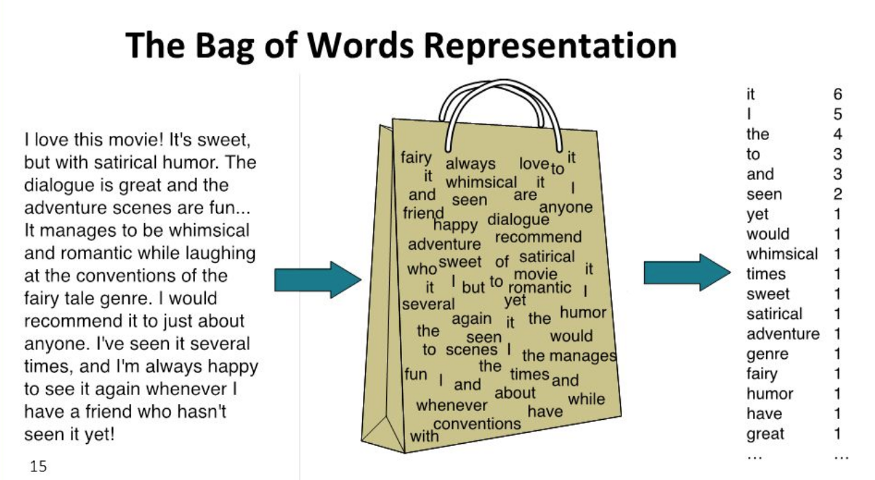

**Advantages**:
- Simplicity: BoW is easy to understand and implement, making it a straightforward method for text representation.
- Interpretability: The resulting vectors in BoW are interpretable, as they represent the frequency of words in a document.
- ...

**Disadvantages**:
- Loss of Sequence Information: BoW disregards the order and sequence of words in a document, leading to a loss of important contextual information.
- Sparsity: BoW vectors are typically sparse because most documents contain only a small subset of the entire vocabulary, making them memory-intensive and challenging for some models.
- No Semantic Understanding: BoW treats words as independent entities, ignoring semantic relationships between words, which can limit its ability to capture meaning.
 - Dimensionality: Bigger corpuses lead to rapid increase in dimentionality of volabulary, complicating calculation and usage of TF-IDF vectors
 - ...

> **TODO**: Add your thoughts to Advantages/Disadvantages

In [17]:
bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    train_test["text"].iloc[:20]
)
l = bag_of_words_object.transform([train_test['text'].iloc[11]]).toarray()[0]
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {train_test['text'].iloc[11]}\n"
    f"Vectorization: {l}"
)

Bag of Words: ['000' '13' '18' '19' '20' '80' 'across' 'afraid' 'alaska' 'all' 'allah'
 'am' 'an' 'and' 'are' 'area' 'areas' 'arrived' 'as' 'asked' 'bago'
 'being' 'both' 'breaking' 'building' 'bus' 'by' 'cafire' 'california'
 'can' 'canada' 'car' 'causes' 'closed' 'colorado' 'coming' 'count'
 'county' 'crash' 'damage' 'days' 'deeds' 'died' 'directions' 'disaster'
 'do' 'due' 'earthquake' 'emergency' 'evacuation' 'expected' 'far' 'fast'
 'fire' 'flash' 'flood' 'flooded' 'flooding' 'florida' 'forest' 'forgive'
 'from' 'fruits' 'fvck' 'getting' 'gonna' 'goooooooaaaaaal' 'got' 'hah'
 'haha' 'happening' 'heat' 'heavy' 'hill' 'hwy' 'in' 'into' 'is' 'just'
 'la' 'lake' 'live' 'lost' 'love' 'lovely' 'man' 'manitou' 'may' 'multi'
 'my' 'myanmar' 'near' 'no' 'notified' 'now' 'of' 'officers' 'on' 'or'
 'orders' 'other' 'our' 'people' 'photo' 'place' 'pours' 'rain' 'raining'
 'reason' 'receive' 'residents' 'rockyfire' 'ronge' 'ruby' 'sask' 'school'
 'second' 'see' 'sent' 'shelter' 'smoke' 'so' 's

In [18]:
bag_of_words_object = CountVectorizer()
bag_of_words_matrix = bag_of_words_object.fit_transform(
    train_test["text"].iloc[:20]
)
r = bag_of_words_object.transform([train_test['light_clean_text'].iloc[11]]).toarray()[0]
print(f"Bag of Words: {bag_of_words_object.get_feature_names_out()}")
print(
    f"Text : {train_test['light_clean_text'].iloc[11]}\n"
    f"Vectorization: {r}"
)

Bag of Words: ['000' '13' '18' '19' '20' '80' 'across' 'afraid' 'alaska' 'all' 'allah'
 'am' 'an' 'and' 'are' 'area' 'areas' 'arrived' 'as' 'asked' 'bago'
 'being' 'both' 'breaking' 'building' 'bus' 'by' 'cafire' 'california'
 'can' 'canada' 'car' 'causes' 'closed' 'colorado' 'coming' 'count'
 'county' 'crash' 'damage' 'days' 'deeds' 'died' 'directions' 'disaster'
 'do' 'due' 'earthquake' 'emergency' 'evacuation' 'expected' 'far' 'fast'
 'fire' 'flash' 'flood' 'flooded' 'flooding' 'florida' 'forest' 'forgive'
 'from' 'fruits' 'fvck' 'getting' 'gonna' 'goooooooaaaaaal' 'got' 'hah'
 'haha' 'happening' 'heat' 'heavy' 'hill' 'hwy' 'in' 'into' 'is' 'just'
 'la' 'lake' 'live' 'lost' 'love' 'lovely' 'man' 'manitou' 'may' 'multi'
 'my' 'myanmar' 'near' 'no' 'notified' 'now' 'of' 'officers' 'on' 'or'
 'orders' 'other' 'our' 'people' 'photo' 'place' 'pours' 'rain' 'raining'
 'reason' 'receive' 'residents' 'rockyfire' 'ronge' 'ruby' 'sask' 'school'
 'second' 'see' 'sent' 'shelter' 'smoke' 'so' 's

In [19]:
np.equal(l,r)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

> **TODO**: Explore https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer  
> Try to use `n-grams`, `stop_words`, `max_features` and other parameters out of the box on both clean text and original


<a id='Tf_Idf'></a>
# [Tf-Idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

TF-IDF is a numerical statistic that quantifies the relevance of a word in a document relative to a corpus of documents. It is widely used in information retrieval and text mining for various NLP tasks, such as document ranking, content recommendation, and text classification.

**Term Frequency (TF)**: This component measures how frequently a term appears in a document. It is calculated as the number of times a term occurs in a document divided by the total number of terms in that document. TF emphasizes the importance of a term within a single document.

`TF = (Number of times term t appears in a document) / (Total number of terms in the document)`

**Inverse Document Frequency (IDF)**: IDF measures the importance of a term across a collection of documents. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term. IDF helps in identifying terms that are rare or unique across the corpus.

`IDF = log(Total number of documents / Number of documents containing term t)`
![tfidf](images/tfidf.png)

**Advantages**:
- Simplicity: simple and fast solution for representing words as numbers relative to corpus.
- Interpretability: highlighs the importance of words in a document relative to a corpus, with higher scores indicating more significant and contextually relevant terms.
- Term Importance and distribution: TF-IDF takes into account not only the frequency of a term in a document (TF) but also its importance in the entire corpus (IDF). 
- ...

**Disadvantages**:
- Loss of Sequence Information: TF-IDF also disregards the order and sequence of words in a document, leading to a loss of important contextual information.
- Lack of Semantic Understanding: TF-IDF doesn't capture the semantic relationships between words. Words with similar meanings are treated independently, potentially leading to a loss of meaning.
- Dimensionality: Bigger corpuses lead to rapid increase in dimentionality of volabulary, complicating calculation and usage of TF-IDF vectors
- ...

> **TODO**: Add your thoughts to Advantages/Disadvantages

In [20]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    train_test["text"].iloc[:20]
)
print(f"Vocab: {tf_idf_object.get_feature_names_out()}")
print(
    f"Text : {train_test['text'].iloc[11]}\n"
    f"Vectorization: {tf_idf_object.transform([train_test['text'].iloc[11]]).toarray()[0]}"
)

Vocab: ['000' '13' '18' '19' '20' '80' 'across' 'afraid' 'alaska' 'all' 'allah'
 'am' 'an' 'and' 'are' 'area' 'areas' 'arrived' 'as' 'asked' 'bago'
 'being' 'both' 'breaking' 'building' 'bus' 'by' 'cafire' 'california'
 'can' 'canada' 'car' 'causes' 'closed' 'colorado' 'coming' 'count'
 'county' 'crash' 'damage' 'days' 'deeds' 'died' 'directions' 'disaster'
 'do' 'due' 'earthquake' 'emergency' 'evacuation' 'expected' 'far' 'fast'
 'fire' 'flash' 'flood' 'flooded' 'flooding' 'florida' 'forest' 'forgive'
 'from' 'fruits' 'fvck' 'getting' 'gonna' 'goooooooaaaaaal' 'got' 'hah'
 'haha' 'happening' 'heat' 'heavy' 'hill' 'hwy' 'in' 'into' 'is' 'just'
 'la' 'lake' 'live' 'lost' 'love' 'lovely' 'man' 'manitou' 'may' 'multi'
 'my' 'myanmar' 'near' 'no' 'notified' 'now' 'of' 'officers' 'on' 'or'
 'orders' 'other' 'our' 'people' 'photo' 'place' 'pours' 'rain' 'raining'
 'reason' 'receive' 'residents' 'rockyfire' 'ronge' 'ruby' 'sask' 'school'
 'second' 'see' 'sent' 'shelter' 'smoke' 'so' 'south' '

In [21]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    train_test["text"].iloc[:20]
)
print(f"Vocab: {tf_idf_object.get_feature_names_out()}")
print(
    f"Text : {train_test['light_clean_text'].iloc[11]}\n"
    f"Vectorization: {tf_idf_object.transform([train_test['light_clean_text'].iloc[11]]).toarray()[0]}"
)

Vocab: ['000' '13' '18' '19' '20' '80' 'across' 'afraid' 'alaska' 'all' 'allah'
 'am' 'an' 'and' 'are' 'area' 'areas' 'arrived' 'as' 'asked' 'bago'
 'being' 'both' 'breaking' 'building' 'bus' 'by' 'cafire' 'california'
 'can' 'canada' 'car' 'causes' 'closed' 'colorado' 'coming' 'count'
 'county' 'crash' 'damage' 'days' 'deeds' 'died' 'directions' 'disaster'
 'do' 'due' 'earthquake' 'emergency' 'evacuation' 'expected' 'far' 'fast'
 'fire' 'flash' 'flood' 'flooded' 'flooding' 'florida' 'forest' 'forgive'
 'from' 'fruits' 'fvck' 'getting' 'gonna' 'goooooooaaaaaal' 'got' 'hah'
 'haha' 'happening' 'heat' 'heavy' 'hill' 'hwy' 'in' 'into' 'is' 'just'
 'la' 'lake' 'live' 'lost' 'love' 'lovely' 'man' 'manitou' 'may' 'multi'
 'my' 'myanmar' 'near' 'no' 'notified' 'now' 'of' 'officers' 'on' 'or'
 'orders' 'other' 'our' 'people' 'photo' 'place' 'pours' 'rain' 'raining'
 'reason' 'receive' 'residents' 'rockyfire' 'ronge' 'ruby' 'sask' 'school'
 'second' 'see' 'sent' 'shelter' 'smoke' 'so' 'south' '

<a id='Word_and_Sentance_Embeddings'></a>
# Word and Sentance Embeddings

**Word embeddings** are distributed representations of words in a <ins>continuous vector space</ins> where each word is mapped to a high-dimensional vector. These vectors are designed in such a way that semantically similar words have similar vector representations, and relationships between words can be captured through vector operations like addition and subtraction.

![image_emb.png](images/word_emb.png)
![image_emb2.png](images/word_emb2.png)

**Advantages**:  
1. **Semantic Understanding**: Word embeddings encode semantic relationships between words. Words with similar meanings or contexts are represented as vectors close to each other in the embedding space, enabling models to understand and leverage semantic information.
---
2. **Improved Generalization**: Word embeddings help NLP models generalize better across tasks and domains. Pre-trained embeddings capture language patterns from large text corpora, allowing models to transfer knowledge from the pre-training to specific tasks with limited training data, which also reduces overfitting and increases robustness.
---
3. **Dimension Reduction**: Word embeddings provide a lower-dimensional representation of words compared to one-hot encoding or Bag of Words (BoW) models. This reduces the computational complexity and the "curse of dimensionality" problem.
---
4. **Contextual Information**: Word embeddings capture the contextual usage of words, allowing models to differentiate between word senses based on context. This is crucial for tasks like word disambiguation.




**Disadvantages**:
1. **Resourse expensive**: Using word embeddings usually requires more computational resourses, most likely GPUs.
---
2. **Ambiguity Handling**: Word embeddings may struggle with word sense disambiguation, as they represent all meanings of a word with a single vector. This can be problematic when a word has different meanings in different contexts.
---
3. **Limited Snterpretability**: embeddings represent words as high-dimensional vectors in a continuous space, making it difficult to directly interpret the meaning of individual dimensions or the relationships between dimensions and semantic concepts

> **TODO**: Add your thoughts to Advantages/Disadvantages

## [Word2Vec](https://arxiv.org/pdf/1301.3781)

[Word2Vec](https://arxiv.org/pdf/1301.3781) is a popular word embedding technique in natural language processing (NLP) that was introduced by Tomas Mikolov and his team at Google in 2013. 

Word2Vec comes in two primary variants:

    Continuous Bag of Words (CBOW): CBOW predicts a target word based on the context words surrounding it. It aims to find the best word representation that can predict the target word from its context.

    Skip-gram: Skip-gram, on the other hand, predicts context words from a given target word. It tries to find the best representation for a word that is useful for predicting the words that surround it in context.

Both CBOW and Skip-gram approaches have their strengths and are used in different contexts depending on the specific NLP task.

![w2v](images/w2v.png)

In [22]:
from contextlib import redirect_stdout, contextmanager
import os


@contextmanager
def suppress():
    with open(os.devnull, "w") as null:
        with redirect_stdout(null):
            yield


In [23]:
import gensim
import gensim.downloader as api


# download the model and return as object ready for use
with suppress():
    word2vec_model = api.load("word2vec-google-news-300")

# Example: Finding similar words
similar_words = word2vec_model.most_similar('king', topn=5)
print("Words similar to 'king':")
for word, score in similar_words:
    print(f"{word}: {score}")

Words similar to 'king':
kings: 0.7138046622276306
queen: 0.6510956883430481
monarch: 0.6413194537162781
crown_prince: 0.6204220056533813
prince: 0.6159993410110474


In [24]:
vector = word2vec_model['king']
print("Vector representation of 'king':")
print(vector)

Vector representation of 'king':
[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582

In [25]:
# Example: Vector arithmetic
result_vector = word2vec_model['actor'] - word2vec_model['man'] + word2vec_model['woman']
similar_word = word2vec_model.similar_by_vector(result_vector, topn=1)
print("Word closest to 'actor - man + woman':")
print(similar_word[0][0])

Word closest to 'actor - man + woman':
actress


### Sentence embeddings
Sentence embeddings, also known as sentence-level embeddings or sentence representations, are numerical representations of entire sentences or text passages. These embeddings capture the semantic meaning and context of a sentence. Unlike word embeddings, which represent individual words, sentence embeddings represent entire sentences as single vectors.



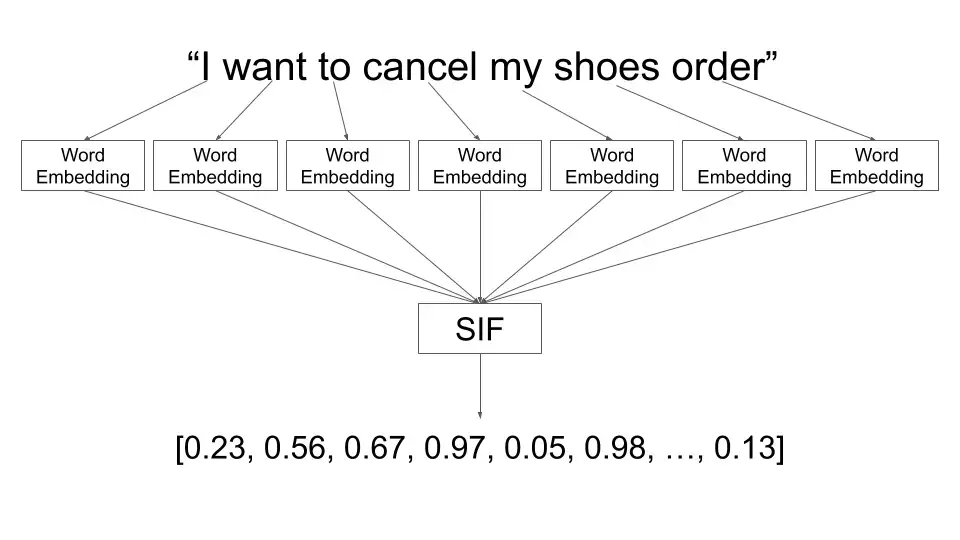
> **Explore**: How can we get sentance embeddings: https://engineering.talkdesk.com/what-are-sentence-embeddings-and-why-are-they-useful-53ed370b3f35

SpaCy, a popular natural language processing library, provides sentence embeddings using pre-trained models like `en_core_web_sm` or `en_core_web_lg` for the English language. These models are built on top of word embeddings (e.g., word2vec or GloVe) and incorporate sentence-level information through techniques such as convolutional neural networks (CNNs) and mean pooling. 

> **Explore**: Read more how sentence embeddings for SpaCy and SentenceTransformers are trained. Links:
> - https://spacy.io/
> - https://www.sbert.net/


In [26]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 587.7 MB 29 kB/s s eta 0:00:01    |█████▊                          | 105.1 MB 8.5 MB/s eta 0:00:57     |████████▍                       | 153.5 MB 9.8 MB/s eta 0:00:45     |████████████████████▍           | 373.6 MB 2.6 MB/s eta 0:01:22     |███████████████████████▏        | 425.6 MB 7.0 MB/s eta 0:00:24 0:00:20     |███████████████████████████████▏| 572.9 MB 10.3 MB/s eta 0:00:02     |████████████████████████████████| 586.8 MB 11.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [27]:
spacy_nlp = spacy.load('en_core_web_lg')

> **TODO**: Try other spacy models

In [28]:
spacy_doc = spacy_nlp(train_test['text'].iloc[11])

> **TODO**: Explore spacy_doc more. What fields can you find there (read official Docs)

In [29]:
print(
    f"Word : {spacy_doc[5]}\n"
    f"Vectorization: {spacy_doc[5].vector}"
)

Word : flooded
Vectorization: [-0.19228  -0.71447  -3.341    -0.57809   0.20356   0.14473   3.6213
  4.4002    1.1705    3.9431   -1.6368   -0.85969  -3.3046    2.5716
  2.8059   -0.56217  -1.1339    0.6126    1.5602   -1.937     1.2355
  1.7196    2.4466    0.31478   0.58042  -1.2548   -1.438    -6.214
  2.1131    1.3942   -0.20633  -1.2626   -1.3043   -2.616    -1.6809
 -3.3024   -3.0038    1.7908    1.262     0.65683  -2.6736   -0.45421
  2.1654    1.1016   -2.5348    2.3473   -1.1994   -0.63449  -0.67225
  1.1998    3.43      2.2331    1.4565   -2.9832    0.23758   0.66052
  1.4784   -1.8348    1.3919    1.7834   -2.2141    0.30022   1.1452
 -2.6368    0.076449  1.3286   -1.8969    5.5672    3.8279    2.3735
 -0.19875  -5.2247   -2.9864    1.7753    0.3758    1.2494    1.9078
  2.9616   -2.8405    0.95295  -0.40785  -0.79733  -0.45103   0.24249
 -0.76289  -1.7353   -0.94429   3.0231   -1.7459    2.4557    3.4611
  1.9968   -1.567     2.9986   -1.8908    1.4718    3.8473   -2.3405
 

In [30]:
print(
    f"Text : {spacy_doc}\n"
    f"Vectorization: {spacy_doc.vector}"
)

Text : Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
Vectorization: [-1.26265199e-03 -9.92876053e-01  2.29996115e-01 -2.77254558e+00
 -2.19458079e+00  5.36285281e-01  1.00411212e+00  7.02371240e-01
 -2.18621635e+00  1.88370419e+00  3.13453883e-01 -1.79694116e+00
  1.12670028e+00 -1.23557162e+00  6.10467136e-01 -6.99343830e-02
  3.87789965e-01  1.07979918e+00 -9.52346027e-01 -3.59413952e-01
  3.14797103e-01  5.62721789e-01  3.34134996e-01 -4.85281423e-02
  4.42771390e-02 -1.37439036e+00  5.01237929e-01  7.86221087e-01
 -8.46826136e-01 -1.30097640e+00 -1.85498476e-01  1.58034170e+00
 -1.11941278e+00  9.78400290e-01  7.11937249e-01 -1.34537816e+00
  7.26411164e-01  1.58156767e-01  1.42276156e+00  1.81150711e+00
  1.36031985e+00  8.92378211e-01  6.23954117e-01 -4.53358203e-01
 -2.18240358e-02  5.59529603e-01 -1.05244219e+00 -1.05062103e+00
 -1.24497688e+00 -6.21377587e-01  1.19173706e+00  7.98578784e-02
 -5

In [15]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")

print(
    f"Text : {train_test['text'].iloc[125]}\n"
    f"Vectorization: {sent_tr.encode([train_test['text'].iloc[125]])[0]}"
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text : Sometimes you face difficulties not because you're doing something wrong but because you're doing something right. - Joel Osteen
Vectorization: [ 6.01482438e-03  4.23101708e-02  4.68300208e-02  6.26826882e-02
  2.30450518e-02  1.91626474e-02  4.30884846e-02 -1.27168372e-02
 -1.02882452e-01 -2.03904994e-02  3.10881045e-02  4.71946225e-02
  1.14810402e-02  2.90902220e-02 -9.51490831e-03 -3.68341804e-02
 -5.50207794e-02  5.14486395e-02 -7.81639479e-03  8.09832886e-02
 -8.20613950e-02  5.38382456e-02 -6.98144063e-02  1.89229902e-02
 -9.50883925e-02  5.88479042e-02 -5.05928099e-02 -3.98263745e-02
  5.52849993e-02 -4.43141460e-02 -2.11008135e-02 -9.59006697e-03
 -3.04084532e-02  1.25017455e-02  3.64139822e-04  6.03896044e-02
 -1.41075542e-02  3.73347700e-02 -1.98013615e-02 -2.28540786e-02
 -1.57507081e-02  2.81592924e-03  6.11275481e-03 -1.03984177e-01
 -1.52559178e-02 -8.69872868e-02 -2.15079114e-02 -1.97220333e-02
  1.39302891e-02 -5.09708785e-02 -7.26656541e-02 -2.72034910e-02
  3.

> **TODO**: Try different *SentenceTransformer* models to get sentence emebeddings from dataset. Some of the selected models to choose from: [list](https://www.sbert.net/docs/pretrained_models.html#model-overview). Try multi-lingual models.

## [Sentence Similarity](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)

How to find simmiliar sentances in text corpus?

1. Extract sentance embeddings
2. Compute pair-wise [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity): $$
\text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}$$
3. Find biggest value of cosine similarity among other texts in text corpus for a particular text

In [16]:
sebert_embeddings = sent_tr.encode(train_test['text'].to_list(), convert_to_tensor=True)

Batches:   0%|          | 0/340 [00:00<?, ?it/s]

In [17]:
cosine_scores = util.cos_sim(sebert_embeddings, sebert_embeddings).detach().cpu().numpy()

In [18]:
text_id = 125
nearest_text_id = np.argsort(cosine_scores[text_id])[-2]

print(
    f"Text: {train_test['text'].iloc[text_id]}\n"
    f"`Nearest` Text: {train_test['text'].iloc[nearest_text_id]}\n"
)

Text: Sometimes you face difficulties not because you're doing something wrong but because you're doing something right. - Joel Osteen
`Nearest` Text: failure is a misfortunebut regret is a catastrophe



## ML at NLP

### Model

*Model* - parametric space of functions (hypotheses):

$\large \mathcal{H} = \left\{ h\left(x, \theta\right) | \theta \in \Theta \right\}$

* where
    * $\large h: X \times \Theta \rightarrow Y$    
    * $\large \Theta$ - parametric space
    * $\large X$ - factor space (exogenous variables)
    * $\large Y$ - target space
    
### Training algorithm


*Training algorithm* - map from data space to hypotheses space:

$\large \mathcal{M}: X \times Y \rightarrow \mathcal{H}$

There are 2 steps in algorithm:
1. Selection of hypothesis: $\large h = \mathcal{M}\left(D\right)$, where $\large D$ - our particular dataset
2. Testing for given example $\large x$ calculation of model prediction $\large \hat{y} = h\left(x\right)$

### Selection of hypothesis

Define *loss function*:
$\large L: Y \times Y \rightarrow \mathbb{R}$ <br>

With loss function we can measure how the prediction $\large \hat {y}$ differs from the ground truth values $\large y$.

$\large Q_{\text{emp}}\left(h\right) = \frac{1}{n} \sum_{i=1}^n L\left(h\left(x_i\right), y_i\right)$, 
where $\large \mathcal{D} = \left\{ \left(x_i, y_i\right) \right\}$ - our training dataset, $\large h$ - hypothesis (function)

We should select hypothesis, that minimizes average loss:
$\large \hat{h} = \arg \min_{h \in \mathcal{H}} Q_{\text{emp}}\left(h\right)$

Examples of loss functions:
* classification: $\large L\left(\hat{y}, y\right) = \text{I}\left[\hat{y} = y\right]$
* regression: $\large L\left(\hat{y}, y\right) = \left(\hat{y} - y\right)^2$

## Example: [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Consider limited space of linear functions with $\large \left(m + 1\right)$ parameters, where one of the parameter refers to bias ($\large x_0 = 1$):

$$\large \begin{array}{rcl} \forall h \in \mathcal{H}, h\left(\vec{x}\right) &=& w_0 x_0 + w_1 x_1 + w_2 x_2 + \cdots + w_m x_m \\
&=& \sum_{i=0}^m w_i x_i \\
&=& \vec{x}^T \vec{w}
\end{array}$$
where:
* $\large \vec{x} \in \mathbb{R}^{m + 1}$

In such a case [Empirical risk](https://en.wikipedia.org/wiki/Empirical_risk_minimization) is equal to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (Mean Squared Error)
$$\large \begin{array}{rcl}\mathcal{L}\left(X, \vec{y}, \vec{w} \right) &=& \frac{1}{n} \sum_{i=1}^n \left(y_i - \vec{x}_i^T \vec{w}_i\right)^2 \\
&=& \frac{1}{n} \left\| \vec{y} - X \vec{w} \right\|_2^2 \\
&=& \frac{1}{n} \left(\vec{y} - X \vec{w}\right)^T \left(\vec{y} - X \vec{w}\right)
\end{array}$$
where:
* $\large \vec{w} \in \mathbb{R}^{m + 1}$
* $\large \vec{y} \in \mathbb{R}^n$
* $\large X$ is $\large n \times m + 1$ matrix, where each row is a feature vector.

Lets find out optimization algorithm. Considering that fact that cost function is convex, we can find point of global minimum:
$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}} \frac{1}{n} \left( \vec{y}^T \vec{y} -2\vec{y}^T X \vec{w} + \vec{w}^T X^T X \vec{w}\right) \\
&=& \frac{1}{n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right)
\end{array}$$

This method is called [Least Squares](https://en.wikipedia.org/wiki/Least_squares) method:
$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} = 0 &\Leftrightarrow& \frac{1}{n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right) = 0 \\
&\Leftrightarrow& -X^T \vec{y} + X^T X \vec{w} = 0 \\
&\Leftrightarrow& X^T X \vec{w} = X^T \vec{y} \\
&\Leftrightarrow& \vec{w} = \left(X^T X\right)^{-1} X^T \vec{y}
\end{array}$$

Another way to come up to the same soulition is <a href="https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem">Gauss–Markov theorem</a>. Also it contains a bunch of interesting properties.

## Example: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.htm)


### Model
Given $\large \mathcal{D} = \left\{ \left(x_i, y_i\right) \right\}$ - our training dataset, $\large \mathcal{H} = \left\{ h\left(x, \theta\right) | \theta \in R^n \right\}$ - logistic regression model

* where
    * $\large x_i \in  R^n$    
    * $\large y_i \in  \left\{0, 1\right\}$
    * $\large h(x_i, \theta) = \sigma \left(\theta ^ T x_i \right) = \dfrac{1}{1 + e ^ \left( - \theta ^ T x_i \right)} = \dfrac{1}{1 + e ^ \left( - \sum_{j=1}^n \theta_j x_{ij} \right)},$ $\large h(x_i, \theta) \in \left(0, 1\right)$
    * $\sigma \left(z\right) = \dfrac{1}{1 + e ^ \left(-z \right)}$ - logistic function, aka sigmoid
    
### Loss function
$y_i \sim Bernoulli(p)$, where p is an unknown parameter <br>
Let's estimate conditional probability $Pr\left\{y_i = 1 | x_i \right\} = \large h(x_i, \theta)$ with Maximum Likelihood Estimation.<br> Obviously, that $Pr\left\{y_i = 0 | x_i \right\} = 1 - \large h(x_i, \theta)$ <br>
Also we can define $Pr\left\{y = y_i | x_i \right\} = \large h(x_i, \theta)^{y_i} \left(1 - \large h(x_i, \theta)\right)^{1 - y_i}$ <br> 
We now calculate the likelihood function assuming that all the observations in the sample are independently Bernoulli distributed: <br>

$L\left(\theta | x\right) = \prod_{i=1}^m Pr\left\{y = y_i | x_i \right\} = \prod_{i=1}^m h\left(x_i, \theta\right)^{y_i} \left(1 - h\left(x_i, \theta\right)\right)^{1 - y_i}$ <br>


Typically, the log likelihood is maximized: 

$log\left(L\left(\theta | x\right) \right) = log\left(\prod_{i=1}^m Pr\left\{y = y_i | x_i \right\}\right) = log\left(\prod_{i=1}^m h\left(x_i, \theta\right)^{y_i} \left(1 - h\left(x_i, \theta\right)\right)^{1 - y_i}\right) = \sum_{i=1}^m log\left(h\left(x_i, \theta\right)^{y_i} \left(1 - h\left(x_i, \theta\right)\right)^{1 - y_i}\right) = \sum_{i=1}^m y_ilog\left(h\left(x_i, \theta\right) \right) + \left(1 - y_i\right) log\left(1 - h\left(x_i, \theta\right) \right)$ <br>

So, finally, we can define our classification loss function as $\large L\left(\hat{y}, y\right) = - ylog\left(\hat{y} \right) - \left(1 - y\right) log\left(1 - \hat{y} \right)$ where $\hat{y} = h\left(x_i, \theta\right) $

Now, when we have dataset, model and loss function, we can perform training and find the best estimation $\large \hat{h} =\arg \min_{h \in \mathcal{H}} \left(\frac{1}{n} \sum_{i=1}^n L\left(h\left(x_i\right), y_i\right)\right)$ <br>

### Optimization
We can find it using Gradient Descent method: <br>
Gradient descent is based on the observation that if the multi-variable function $\large F$ is defined and differentiable in a neighborhood of a point $\large a$, then $\large F$ decreases fastest if one goes from a in the direction of the negative gradient of $\large F$ at $\large a$. <br>

Define $\vec{w_{n + 1}} = \vec{w_{n}} - \alpha\frac{\partial \mathcal{L}}{\partial \vec{w}} \left(\vec{w_{n}}\right)$, where $\alpha$ is a small number, called learning rate. <br>

If $\vec{w_{n}}$ converges, then it converges to local minimum. If $\mathcal{L}$ is a convex function, then $\vec{w_{n}}$ converges to the global minimum.

In our case of optimization our loss function (log-loss) for logistic regression model: <br>

$$\large \begin{array}{rcl} - \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}}\sum_{i=1}^n y_i \ln \sigma\left(\vec{w}^T \vec{x}_i\right) + \left(1 - y_i\right) \ln \left(1 - \sigma\left(\vec{w}^T \vec{x}_i\right)\right) \\
&=& \sum_{i=1}^n y_i \frac{1}{\sigma} \sigma \left(1 - \sigma\right) \vec{x}_i + \left(1 - y_i\right) \frac{1}{1 - \sigma} \left(-1\right)\sigma \left(1 - \sigma\right) \vec{x}_i \\
&=& \sum_{i=1}^n y_i \left(1 - \sigma\right) \vec{x}_i - \left(1 - y_i\right) \sigma \vec{x}_i \\
&=& \sum_{i=1}^n \vec{x}_i \left(y_i - \sigma\right)
\end{array}$$

> **TODO**: Read about:
>    * Polinimial Regression
>    * Feature Correlation Problem
>    * Regularization (L1, L2)
>    * Feature Scaling, especially Standarization
>    * Ensembling (at first about Descion Trees, then how to ensemble them: Random Forest, Gradient Boosting)




## Train Logistic Regression model

In [19]:
train["light_clean_text"] = train['text'].apply(process_light)
test["light_clean_text"] = test['text'].apply(process_light)
train.head(5)

,id,keyword,location,text,target,is_train,light_clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,True,Our Deeds are the Reason of this May ALLAH Fo...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,True,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,True,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,True,"13,000 people receive evacuation orders in Ca..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,True,Just got sent this photo from Ruby as smoke f...


In [20]:
def comp_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    return f1_score(y_true, y_pred)

In [21]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(train, train["target"])]

Let's check dummy predictions first for baseline:

In [22]:
print("Zero Prediction", comp_metric(train['target'].values, np.zeros_like(train['target'].values)))
print("One Prediction", comp_metric(train['target'].values, np.ones_like(train['target'].values)))
print("Ideal Prediction", comp_metric(train['target'].values, train['target'].values))
print(
    "Random Prediction", comp_metric(
    train['target'].values, 
    np.random.binomial(n=1, p=0.5, size=train['target'].values.shape))
)

Zero Prediction 0.0
One Prediction 0.6010657846380006
Ideal Prediction 1.0
Random Prediction 0.4678147939017504


We will try two approaches:
- logistic regression + bag of words
- logistic regression + sentence embeddings

### logistic regression + bag of words

In [23]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("lof_reg", LogisticRegression())
    ])
    model.fit(train["light_clean_text"].iloc[train_ids], train['target'].iloc[train_ids])
    fold_train_preds = model.predict(train["light_clean_text"].iloc[train_ids])
    fold_test_preds = model.predict(train["light_clean_text"].iloc[test_ids])
    fold_train_targets = train['target'].iloc[train_ids].values
    fold_test_targets = train['target'].iloc[test_ids].values
    print(f"Fold {fold_id+1}")
    print("Train:\t", comp_metric(fold_train_targets, fold_train_preds))
    print("Test:\t", comp_metric(fold_test_targets, fold_test_preds))
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)
    print()

Fold 1
Train:	 0.9495467087110759
Test:	 0.7532679738562091

Fold 2
Train:	 0.9499013806706115
Test:	 0.7594108019639934

Fold 3
Train:	 0.949085905248673
Test:	 0.7178658043654003

Fold 4
Train:	 0.9517836142689142
Test:	 0.7321131447587355

Fold 5
Train:	 0.9498618239242006
Test:	 0.7582236842105263



In [24]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train:\t",comp_metric(all_train_targets, all_train_preds))
print("OOF Test:\t",comp_metric(all_test_targets, all_test_preds))

OOF Train:	 0.950037403047364
OOF Test:	 0.7441403048680544


> **Explore**: Model explainability: [eli5](https://eli5.readthedocs.io/en/latest/)


### logistic regression + sentence embeddings

In [25]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")

train_embs = sent_tr.encode(train["light_clean_text"].to_list())
test_embs = sent_tr.encode(test["light_clean_text"].to_list())

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("scaler", MinMaxScaler()),
        ("lof_reg", LogisticRegression(max_iter=1000))
    ])
    model.fit(train_embs[train_ids], train['target'].iloc[train_ids])
    fold_train_preds = model.predict(train_embs[train_ids])
    fold_test_preds = model.predict(train_embs[test_ids])
    fold_train_targets = train['target'].iloc[train_ids].values
    fold_test_targets = train['target'].iloc[test_ids].values
    print(f"Fold {fold_id+1}")
    print("Train:\t", comp_metric(fold_train_targets, fold_train_preds))
    print("Test:\t", comp_metric(fold_test_targets, fold_test_preds))
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)
    print()

Fold 1
Train:	 0.7928923988153999
Test:	 0.7790788446526151

Fold 2
Train:	 0.7921381774865991
Test:	 0.7598736176935229

Fold 3
Train:	 0.7937264244590033
Test:	 0.7494071146245059

Fold 4
Train:	 0.7937959832968782
Test:	 0.7671451355661881

Fold 5
Train:	 0.7890454455249057
Test:	 0.7623604465709729



In [30]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train:\t",comp_metric(all_train_targets, all_train_preds))
print("OOF Test:\t",comp_metric(all_test_targets, all_test_preds))

OOF Train:	 0.792319593763637
OOF Test:	 0.7636075949367088


In [34]:
test_pred = []
for m in all_models:
    fold_test_pred = m.predict_proba(test_embs)
    test_pred.append(fold_test_pred)

In [50]:
preds = np.array(test_pred).mean(axis=0).argmax(axis=1)
sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
sub['target']=preds
sub.to_csv('bert_emb_logreg.csv',index=False)

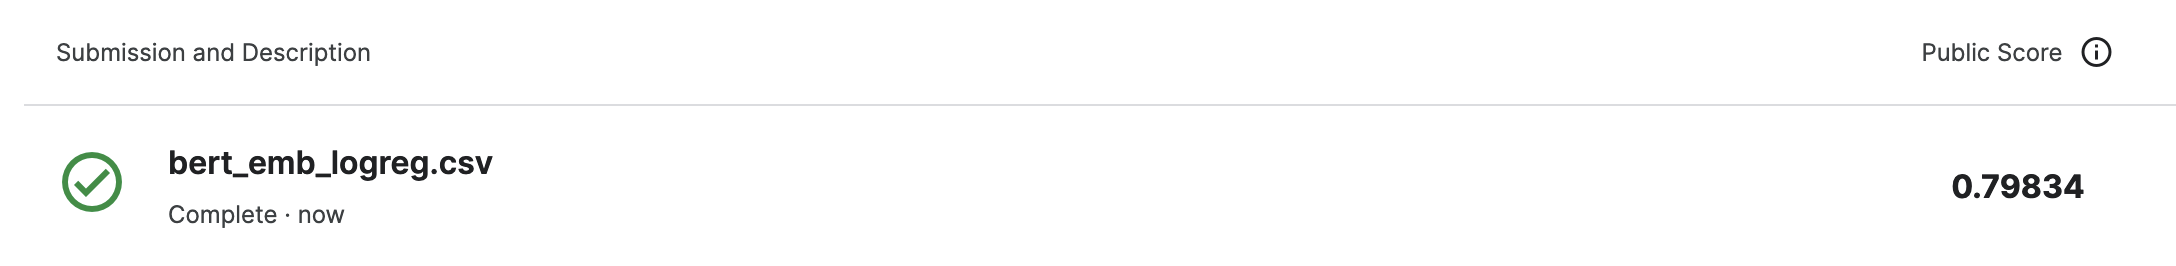

We got a lower F1-score on train, but closer to our validation value. Our valid-F1 is higher using BERT SentenceEmbeddings, so we submitted our prediction to LB and got an imrovement in comperison to last lecture. Also, our validation correlates with leaderboard, which is a good sign.

Of course, it is possible to improve that score further. Perform hyperparamter tunning, use other columns, do better preprocessing, try different model, etc.

> **TODO**: 
> - tweak parameters of CountVectorizer, try to find better setup
> - try with TF-IDF, tweak it's parameters
> - different embeddings (avg emb of word2wec of sentence, SpaCy,  SentenceTransformers)
> - tune parameters of Logistic Regression. You can use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [HyperOpt](http://hyperopt.github.io/hyperopt/) for hyper-parameter optimization
> - try with different classic ML models ([Gradient boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier), [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), etc)

***IMPORTANT***: be cautious, use validation to choose parameters of models and deciding on the best model + text representeation combination.

# Homework

**Theory** (6 points):

>Read Explore comments. Follow links.  
>Answer theory questions in the Google Form.

**Practice** (9 points):

Take into account all **TODO** left by us in code. They might give you good insights.
        
> For the [CommonLit - Evaluate Student Summaries](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/) task and dataset aim to improve compettion score both on validation and leaderboard. Try the following:
> - improve data processing (text proccessing techniques), feature selection;
> - tweak vectorization, use both Bag Of Words, TF-IDF (hint: read docs to modify their parameters) and Sentence embeddings (word2vec, SpaCy, BERT Sentence Transformers, etc);
> - changing model hyperparameters, adding regularization


> *Advanced*: Take a look at **TODO** one more time. Maybe you can improve our notebook.


